# Import packages

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import tools
import torch
from torch.nn.functional import grid_sample

# Choose Parameters

In [2]:
dx = 30 # choose rasterizing resolution pixel size


# SPECIFY WHAT THESE PARAMETERS ARE
niter = 1000
eA = 1e5
ev = 5e8
start3d = 500
startdiff = 800
niter = 3000
sigmaR = 1e9
nt = 4

#output folder
outname = 'output/'

# Load Target Data

In [3]:
#Load file
#Must be a dataframe with cell positions
#columns center_x, center_y, volume only floats
filename = '__'
df = pd.read_csv(r'/home/manju/Documents/test/well11_spatial.csv.gz')
                 
x = np.array(df['X'])
x = np.delete(x,0)
x = np.array([float(numeric_string)/2 for numeric_string in x])

y = np.array(df['Y'])
y = np.delete(y,0)
y = np.array([float(numeric_string)/2 for numeric_string in y])

v = np.array(df['Z'])
v = np.delete(v,0)
v = np.array([float(numeric_string) for numeric_string in v])

N = x.shape[0] 

In [4]:
#Rasterize Image
X_,Y_,W = tools.rasterize(x,y,dx=dx,draw=False)     

<IPython.core.display.Javascript object>


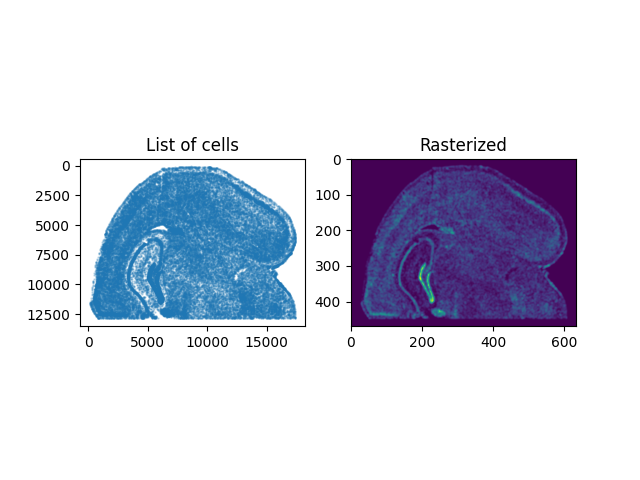

In [5]:
#Plot unrasterized/rasterized images
fig,ax = plt.subplots(1,2)
ax[0].scatter(x,y,s=0.5,alpha=0.25)
ax[0].invert_yaxis()
ax[0].set_title('List of cells')
ax[0].set_aspect('equal')

W = W[0]
extent = (X_[0],X_[-1],Y_[0],Y_[-1])    
ax[1].imshow(W,  origin='lower')    
ax[1].invert_yaxis()    
ax[1].set_title('Rasterized')

# save figure
fig.canvas.draw()    
fig.savefig(outname[:-4]+'_image.png')

# Load Allen Brain Atlas

In [6]:
#ontology_name = 'allen_ontology.csv'

#labelfile = 'annotation_50.nrrd'
#imagefile = 'ara_nissl_50.nrrd'

In [7]:
#Download and store ontology
if ('ontology_name' in locals()) == False:
    url = 'http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]'
    r = requests.get(url)
    print(r)
    with open('allen_ontology.csv','w') as f:
        f.write(r.text)
    ontology_name = 'allen_ontology.csv'

O = pd.read_csv(ontology_name)

# store the ontology in a dictionary
namesdict = defaultdict(lambda: 'unk')
namesdict[0] = 'bg'

# we need to add the structure names from the structure_id
for i,n in zip(O['id'],O['acronym']):
    namesdict[i] = n

<Response [200]>


In [8]:
#Download and store Allen Brain Atlas
if ('imagefile' in locals()) == False:
    url = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/ara_nissl/ara_nissl_50.nrrd'
    r = requests.get(url, stream=True)
    with open('aba_nissl.nrrd', 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    imagefile = 'aba_nissl.nrrd'
    
if ('labelfile' in locals()) == False:
    url = 'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
    r = requests.get(url, stream=True)
    with open('aba_annotation.nrrd', 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    labelfile = 'aba_annotation.nrrd'

# Find initial rotation and slice in ABA

<IPython.core.display.Javascript object>


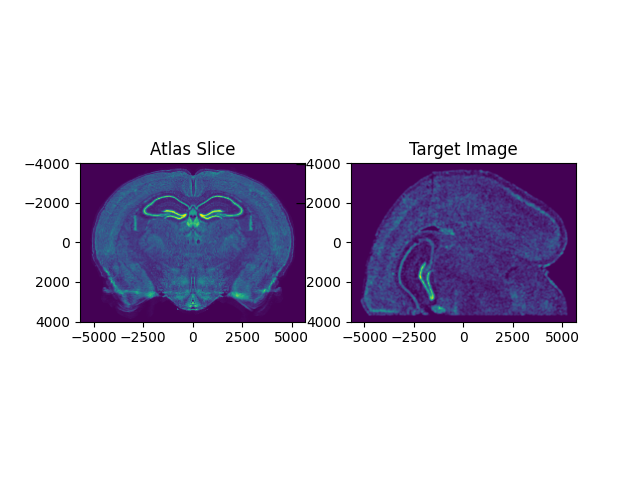

In [9]:
#find slice
#peruse through images in atlas
# Loading the atlas
slice = 138

vol,hdr = nrrd.read(imagefile)
A = vol    
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = tools.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    


<IPython.core.display.Javascript object>


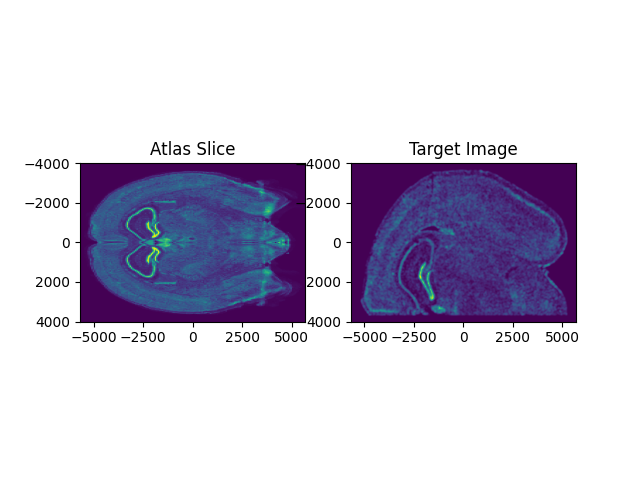

In [13]:
#Rotation
from scipy.ndimage import rotate

theta_deg = 90

#L = np.array([[1.0,0.0,0.0],
#             [0.0,np.cos(theta0),-np.sin(theta0)],
#              [0.0,np.sin(theta0),np.cos(theta0)]])

fig,ax = plt.subplots(1,2)
extentA = tools.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title('Atlas Slice')

ax[1].imshow(W0,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()    


In [12]:
#Correct for scaling
#STARmap half brain slice, y is half the ABA
import cv2

W0 = cv2.resize(W, [469, 315])

In [14]:
W0.shape

(315, 469)

# Perform LDDMM

In [15]:
# initialize variables
theta0 = (np.pi/180)*theta_deg
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

# get an initial guess
T = np.array([-xI[0][slice],np.mean(xJ[0])+1000,np.mean(xJ[1])])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])*0.9

/home/manju/anaconda3/envs/stalign_ma/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


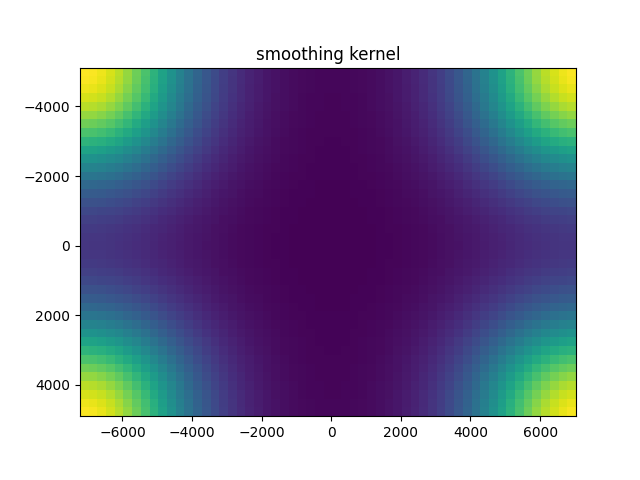

<IPython.core.display.Javascript object>


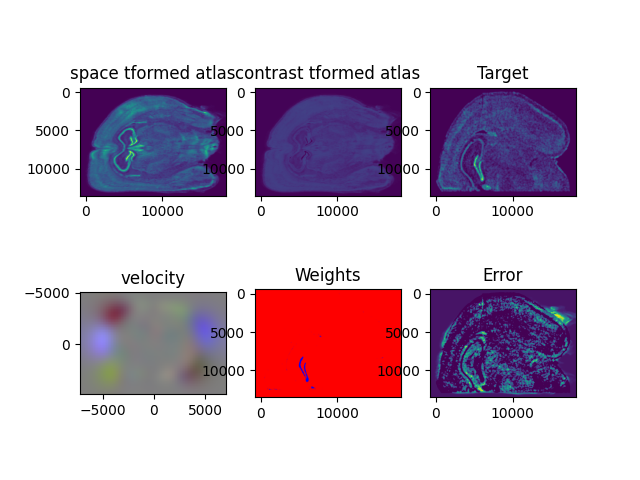

<IPython.core.display.Javascript object>


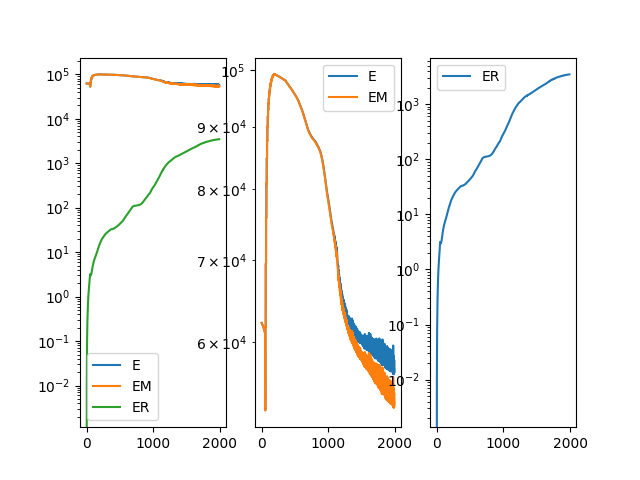

/home/manju/Documents/STalign/tools.py:1563: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axE[2].set_yscale('log')


In [16]:
import importlib
importlib.reload(tools)

#returns mat = , v = , xv = 
mat,v,xv = tools.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=nt,niter=2000,
    device='cuda'
)


# Something Else ?

/home/manju/anaconda3/envs/stalign_ma/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<IPython.core.display.Javascript object>


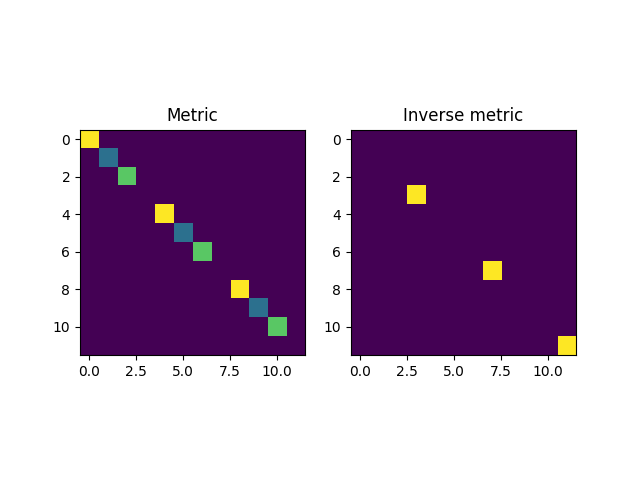

<IPython.core.display.Javascript object>


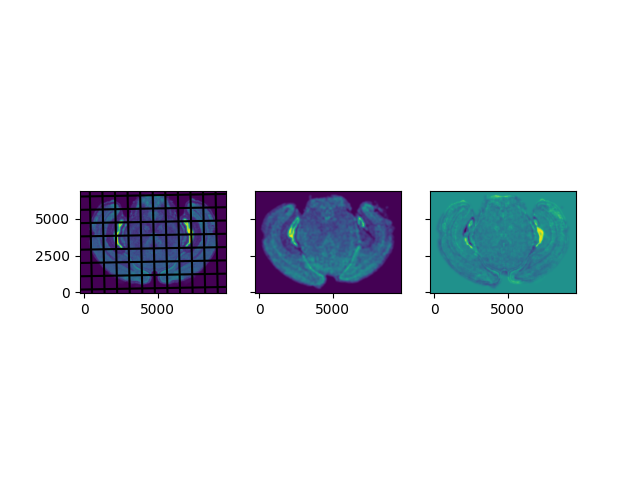

<IPython.core.display.Javascript object>


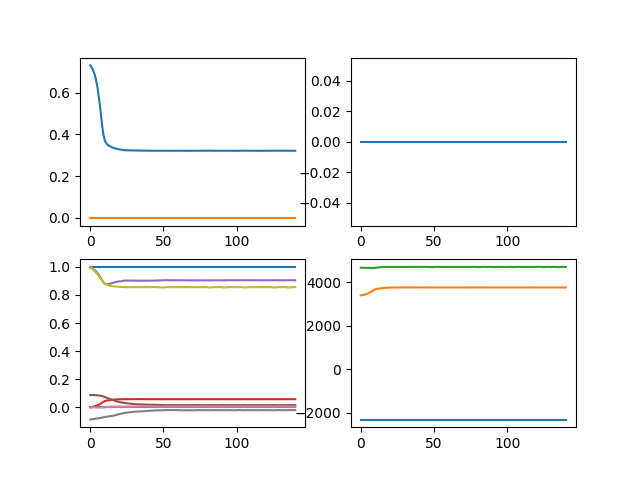

In [12]:
# now we will use torch            
dtype = torch.float
device = 'cpu'
I = torch.as_tensor(A[None]/np.mean(np.abs(A)),dtype=dtype,device=device)
J = torch.as_tensor(W[None,None]/np.mean(np.abs(W)),dtype=dtype,device=device)
xI = [torch.as_tensor(x,dtype=dtype,device=device) for x in xA]
xJ = [torch.as_tensor([0.0],device=device,dtype=dtype),
      torch.as_tensor(Y_,device=device,dtype=dtype),
      torch.as_tensor(X_,device=device,dtype=dtype)]
XJ = torch.stack(torch.meshgrid(xJ),-1)
XI = torch.stack(torch.meshgrid(xI),-1)

# velocity
dI = torch.tensor([x[1]-x[0] for x in xI])    
dv = dI*3
buf = 20
xv = [torch.arange(x[0]-dIi*buf,x[-1]+dIi*buf,dvi) for x,dIi,dvi in zip(xI,dI,dv)]
a = dv[0]*3.0
p = 2.0
nv = torch.tensor([len(x) for x in xv])
XV = torch.stack(torch.meshgrid(xv),-1)
fv = [torch.arange(n)/d/n for n,d in zip(nv,dv)]
FV = torch.stack(torch.meshgrid(fv),-1)
LL = (1.0 - 2.0*a**2 * 
              ( (torch.cos(2.0*np.pi*FV[...,0]*dv[0]) - 1)/dv[0]**2  
            + (torch.cos(2.0*np.pi*FV[...,1]*dv[1]) - 1)/dv[1]**2  
            + (torch.cos(2.0*np.pi*FV[...,2]*dv[2]) - 1)/dv[2]**2   ) )**(p*2)
K = 1.0/LL

# metric
# we'll use the pullback on the points in the atlas    
g = torch.zeros((12,12))
count = 0
for i in range(12):
    Ei = (torch.arange(16)==i).reshape((4,4))*1.0
    EiXI = (Ei[:3,:3]@XI[...,None])[...,0] + Ei[:3,-1]
    for j in range(12):
        Ej = (torch.arange(16)==j).reshape((4,4))*1.0
        EjXI = (Ej[:3,:3]@XI[...,None])[...,0] + Ej[:3,-1]
        g[i,j] = torch.mean(torch.sum(EiXI*EjXI,-1))

gi = torch.inverse(g)
fig,ax = plt.subplots(1,2)
ax[0].imshow(g)
ax[0].set_title('Metric') 
ax[1].imshow(gi)    
ax[1].set_title('Inverse metric') 
fig.canvas.draw()


# affine matrix 
L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)    
L.data[1,1] = np.cos(theta0)
L.data[2,1] = np.sin(theta0)
L.data[1,2] = -np.sin(theta0)
L.data[2,2] = np.cos(theta0)
T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
T.data[0] = -xI[0][slice]
# 
T.data[1] = np.mean(Y_)
T.data[2] = np.mean(X_)    




v = torch.zeros((nt,nv[0],nv[1],nv[2],3),requires_grad=True)


f0,ax0 = plt.subplots(1,3,sharex=True,sharey=True)
f1,ax1 = plt.subplots(2,2)
ax1 = ax1.ravel()



Esave = []
ERsave = []
Tsave = []
Lsave = []
for it in range(niter):
    # generate
    phii = tools.v_to_phii_3D(xv,v.permute(0,4,1,2,3))
    # apply affine transform to atlas
    A = tools.to_A_3D(L,T)
    # invert
    Ai = torch.inverse(A)
    # sample points
    Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]

    # compose
    Xs = (tools.interp3D(xv,phii-XV.permute(3,0,1,2),Xs.permute(3,0,1,2)) + Xs.permute(3,0,1,2)).permute(1,2,3,0)

    # transform atlas
    AI = tools.interp3D(xI,I,Xs.permute(3,0,1,2))
    # contrast
    AI0 = AI - torch.mean(AI)
    if it == 0:
        Jbar = torch.mean(J)
        J0 = J - Jbar
    fAI = AI0 * torch.mean(AI0*J0) / torch.mean(AI0**2) + Jbar
    # cost
    err = fAI-J
    E = torch.mean(err**2)        
    vhat = torch.fft.fftn(v.permute(0,4,1,2,3),dim=(-1,-2,-3))        
    ER = torch.sum(torch.sum(torch.abs(vhat)**2,(0,1))*LL)/torch.prod(nv)*torch.prod(dv)/nt/2.0/sigmaR**2
    E = E + ER
    E.backward()

    Esave.append(E.item())
    ERsave.append(ER.item())
    Lsave.append(L.detach().clone().cpu().numpy().ravel())
    Tsave.append(T.detach().clone().cpu().numpy().ravel())

    # draw
    if not it%10:
        ax0[0].cla()
        ax0[0].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower')
        ax0[1].cla()
        ax0[1].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
        ax0[2].cla()
        ax0[2].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')

        ax1[0].cla()
        ax1[0].plot(Esave)
        ax1[0].plot(ERsave)
        ax1[1].cla()
        ax1[1].plot(ERsave)
        ax1[2].cla()
        ax1[2].plot(Lsave)
        ax1[3].cla()
        ax1[3].plot(Tsave)

        # it would be good to draw the transform
        levels = torch.arange(-10000.0,10000.0,1000.0,device=device,dtype=dtype)    
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,0].detach().cpu().numpy(),levels,colors='k',linestyles='-')
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,1].detach().cpu().numpy(),levels,colors='k',linestyles='-')
        ax0[0].contour(xJ[2].cpu().numpy(),xJ[1].cpu().numpy(),Xs[0,...,2].detach().cpu().numpy(),levels,colors='k',linestyles='-')

        f0.canvas.draw()
        f1.canvas.draw()

    # update
    with torch.no_grad():
        # some heuristicis are used in terms of step sizes
        # combine grads
        grad = torch.cat((L.grad,T.grad[:,None]),-1).reshape(12)
        grad = (gi@grad).reshape(3,4)

        if it > start3d:
            if it == start3d+1:                    
                eA /= 5                
            L -= grad[:3,:3]*eA
            T -= grad[:3,-1]*eA

        else:                            
            L[1:] -= grad[:3,:3][1:]*eA
            T[1:] -= grad[:3,-1][1:]*eA
        L.grad.zero_()
        T.grad.zero_()

        if it > startdiff:
            #vgrad = torch.irfft(torch.rfft(v.grad.permute(0,4,1,2,3),signal_ndim=3,onesided=False)*K[None,None,...,None],signal_ndim=3,onesided=False).permute(0,2,3,4,1)
            vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad.permute(0,4,1,2,3),dim=(-1,-2,-3))*K[None,None],dim=(-1,-2,-3)).permute(0,2,3,4,1).real
            v -= vgrad*ev
        v.grad.zero_()


f0.savefig(outname[:-4]+'_maps.png')
f1.savefig(outname[:-4]+'_cost.png')


# map the annotations
vol,hdr = nrrd.read(labelfile)
# we require 64 bit here or there will be trouble
S = torch.as_tensor(vol.astype(np.float64)[None],dtype=torch.float64,device=device) # note we need float for interp
AS = torch.round(tools.interp3D(xI,S,Xs.permute(3,0,1,2).double(),mode='nearest')).int()

fig,ax = plt.subplots()
ax.imshow((AS[0,0]%7).detach().cpu().numpy(),
          origin='lower',extent=extent)
ax.set_title('Labels')
fig.canvas.draw()
fig.savefig(outname[:-4]+'_labels.png')
samples = torch.stack([torch.zeros(len(x),device=device,dtype=dtype),
                       torch.as_tensor(y,device=device,dtype=dtype),
                       torch.as_tensor(x,device=device,dtype=dtype)],-1)      

# Export Annotations

In [ ]:
# here is an update
col = ((x - X_[0])/dx).astype(int)
row = ((y - Y_[0])/dx).astype(int)
out = AS[0,0,row,col]
out0 = Xs[0,row,col,0]
out1 = Xs[0,row,col,1]
out2 = Xs[0,row,col,2]


# get ready for writing    
df['structure_id'] = out
df['atlas_coord_0'] = out0.detach().cpu()
df['atlas_coord_1'] = out1.detach().cpu()
df['atlas_coord_2'] = out2.detach().cpu()

all_names = [namesdict[i] for i in df['structure_id']]
df['acronym'] = all_names    
df.to_csv(outname + '_annotations.csv')
